In [1]:
!pip install pygam
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from pygam import LinearGAM, GAM, s
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df = pd.read_csv('redone_data_analysis6.csv', index_col=0)

# Encoding Minimum Qualification as Factors

In [2]:
# df['School Level'] = np.nan
# df.loc[df['Minimum Qual Requirements'].str.lower().str.contains('high school', na=False), 'School Level'] = 'High School'
# df.loc[df['Minimum Qual Requirements'].str.lower().str.contains('baccalaureate|college', na=False), 'School Level'] = "Bachelor's"
# df.loc[df['Minimum Qual Requirements'].str.lower().str.contains("master's", na=False), 'School Level'] = "Master's"
# df.loc[df['Minimum Qual Requirements'].str.lower().str.contains("professional engineer|registration as an architect", na=False), 'School Level'] = "Engineer/Architect License"
# df.loc[df['Minimum Qual Requirements'].str.lower().str.contains("state bar", na=False), 'School Level'] = "Bar"
# df.loc[df['Minimum Qual Requirements'].str.lower().str.contains("housing manager", na=False), 'School Level'] = "Housing Manager"

# Standardizing Salary Frequencies

In [3]:
# # Converting all salaries to annual
# df.loc[df['Salary.Frequency'] == 'Hourly', 'Salary.Range.From'] = df['Salary.Range.From'] * 2080
# df.loc[df['Salary.Frequency'] == 'Hourly', 'Salary.Range.To'] = df['Salary.Range.To'] * 2080

# Vectorizing Preferred Skills Columns

In [4]:
lst = list(zip(df['Business.Title'], df['Preferred.Skills']))
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = .8, min_df = 10)
td_matrix = vectorizer.fit_transform([str(i[1]) for i in lst])

In [5]:
docs_compressed, s, words_compressed = svds(td_matrix, k=100)
words_compressed = words_compressed.T
docs_normed = normalize(docs_compressed)

In [6]:
columns = df.columns
dictionary = {i : col for i, col in enumerate(columns)}
new_dataframe = pd.concat([df, pd.DataFrame(docs_normed)], axis=1, ignore_index=True)
new_dataframe = new_dataframe.iloc[0:851]
new_dataframe.rename(dictionary, axis=1, inplace=True)

In [7]:
# Fitting Generalized Additive Model on Data
dummies = pd.get_dummies(df[['level_factor', 'School.Level', 'Agency']])
vectors = list(np.arange(18, 118).astype(str)) + ['Posting.Type']
X_factors = pd.concat([df[vectors], dummies], axis=1)
X = X_factors.values
y = (df['Salary.Range.From'] - df['Salary.Range.From'].mean())/df['Salary.Range.From'].std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
lams = np.random.rand(50, 138)
lams = np.exp(lams)
gam = LinearGAM(n_splines=10).gridsearch(X_train, y_train, lam=lams)
gam.summary()
print(mean_squared_error(y_test, gam.predict(X_test)))

100% (50 of 50) |########################| Elapsed Time: 0:05:04 Time:  0:05:04
<ipython-input-7-e7f19f46cc2a>:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    196.8473
Link Function:                     IdentityLink Log Likelihood:                                  -547.7437
Number of Samples:                          595 AIC:                                              1491.182
                                                AICc:                                            1689.7994
                                                GCV:                                                0.5159
                                                Scale:                                              0.2222
                                                Pseudo R-Squared:                                   0.8513
Feature Function                  Lam

0.2685032116455514


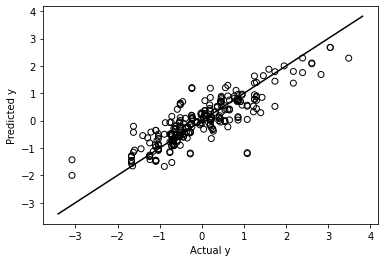

In [8]:
pred = gam.predict(X_test)
plt.scatter(y_test, pred, facecolors='none', edgecolors='black')
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', c='black')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
abline(1, 0)